In [ ]:
# Google Colab에서 노트북을 실행하실 때에는
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
%matplotlib inline

# Dataset과 DataLoader


데이터 샘플을 처리하는 코드는 지저분(messy)하고 유지보수가 어려울 수 있습니다;
더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적입니다.
PyTorch는 ``torch.utils.data.DataLoader`` 와 ``torch.utils.data.Dataset`` 의 두 가지 데이터 기본 요소를
제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 합니다.
``Dataset`` 은 샘플과 정답(label)을 저장하고, ``DataLoader`` 는 ``Dataset`` 을 샘플에 쉽게 접근할 수 있도록
순회 가능한 객체(iterable)로 감쌉니다.

PyTorch의 도메인 특화 라이브러리들은 (FashionMNIST와 같은) 미리 준비해둔(pre-loaded) 다양한 데이터셋을 제공합니다.
데이터셋은 ``torch.utils.data.Dataset`` 의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있습니다.
이러한 데이터셋은 모델을 만들어보고(prototype) 성능을 측정(benchmark)하는데 사용할 수 있습니다.
여기에서 데이터셋들을 찾아볼 수 있습니다:
[이미지 데이터셋](https://pytorch.org/vision/stable/datasets.html),
[텍스트 데이터셋](https://pytorch.org/text/stable/datasets.html) 및
[오디오 데이터셋](https://pytorch.org/audio/stable/datasets.html)




## 데이터셋 불러오기

`TorchVision` 에서 [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) 데이터셋을
불러오는 예제를 살펴보겠습니다. Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있습니다.
각 예제는 흑백(grayscale)의 28x28 이미지와 10개 분류(class) 중 하나인 정답(label)으로 구성됩니다.

다음 매개변수들을 사용하여 [FashionMNIST 데이터셋](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) 을 불러옵니다:
 - ``root`` 는 학습/테스트 데이터가 저장되는 경로입니다.
 - ``train`` 은 학습용 또는 테스트용 데이터셋 여부를 지정합니다.
 - ``download=True`` 는 ``root`` 에 데이터가 없는 경우 인터넷에서 다운로드합니다.
 - ``transform`` 과 ``target_transform`` 은 특징(feature)과 정답(label) 변형(transform)을 지정합니다.



In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:12<00:00, 2126806.03it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202425.42it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3765558.78it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19558221.91it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## 데이터셋을 순회하고 시각화하기

``Dataset`` 에 리스트(list)처럼 직접 접근(index)할 수 있습니다: ``training_data[index]``.
``matplotlib`` 을 사용하여 학습 데이터의 일부를 시각화해보겠습니다.



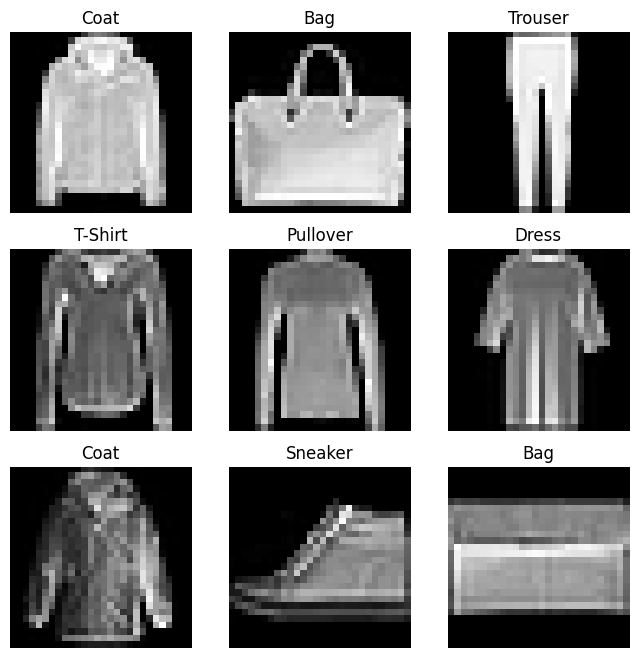

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

..
 .. figure:: /_static/img/basics/fashion_mnist.png
   :alt: fashion_mnist



------------------------------------------------------------------------------------------




## 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: `__init__`, `__len__`, and `__getitem__`.
아래 구현을 살펴보면 FashionMNIST 이미지들은 ``img_dir`` 디렉토리에 저장되고, 정답은 ``annotations_file`` csv 파일에
별도로 저장됩니다.

다음 장에서 각 함수들에서 일어나는 일들을 자세히 살펴보겠습니다.



In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### __init__

__init__ 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행됩니다.
여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 (다음 장에서 자세히 살펴볼) 두가지
변형(transform)을 초기화합니다.

labels.csv 파일은 다음과 같습니다: ::

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9



In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### __len__

__len__ 함수는 데이터셋의 샘플 개수를 반환합니다.

예:



In [ ]:
def __len__(self):
    return len(self.img_labels)

### __getitem__

__getitem__ 함수는 주어진 인덱스 ``idx`` 에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다.
인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, ``read_image`` 를 사용하여 이미지를 텐서로 변환하고, ``self.img_labels`` 의 csv 데이터로부터
해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환합니다.



In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample

------------------------------------------------------------------------------------------




## DataLoader로 학습용 데이터 준비하기

``Dataset`` 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다.
모델을 학습할 때, 일반적으로 샘플들을 "미니배치(minibatch)"로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고,
Python의 ``multiprocessing`` 을 사용하여 데이터 검색 속도를 높이려고 합니다.

``DataLoader`` 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)입니다.



In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoader를 통해 순회하기(iterate)

``DataLoader`` 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다.
아래의 각 순회(iteration)는 (각각 ``batch_size=64`` 의 특징(feature)과 정답(label)을 포함하는) ``train_features`` 와
``train_labels`` 의 묶음(batch)을 반환합니다. ``shuffle=True`` 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다.
(데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)
를 살펴보세요.)



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


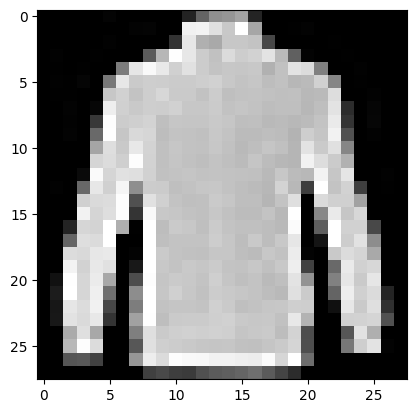

Label: 4


In [ ]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

------------------------------------------------------------------------------------------


